In [1]:
import pandas as pd
from db.database import dbSession
from db.crud import get_model_all_record
from db.models import CaHousingDatum
import dotenv
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
dotenv.load_dotenv(".env", override=True)
DATABASE_URI = os.getenv("DATABASE_URI")

In [3]:
db_session = dbSession(DATABASE_URI)
db_session.create_session()

In [4]:
records_df = get_model_all_record(db_session.session, CaHousingDatum)
records_df = [x.__dict__ for x in records_df]
df = pd.DataFrame(data=records_df)
df = df.set_index("row_id", drop=True)
df = df.drop(columns=["_sa_instance_state"])
df = df.reset_index(drop=True)

In [5]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
df.describe()

,longitude,housing_median_age,total_bedrooms,households,median_house_value,latitude,total_rooms,population,median_income
count,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,28.639486,537.870553,499.539680,206855.816909,35.631861,2635.763081,1425.476744,3.870671
std,2.003532,12.585558,421.385070,382.329753,115395.615874,2.135952,2181.615252,1132.462122,1.899822
min,-124.350000,1.000000,1.000000,1.000000,14999.000000,32.540000,2.000000,3.000000,0.499900
25%,-121.800000,18.000000,296.000000,280.000000,119600.000000,33.930000,1447.750000,787.000000,2.563400
50%,-118.490000,29.000000,435.000000,409.000000,179700.000000,34.260000,2127.000000,1166.000000,3.534800
75%,-118.010000,37.000000,647.000000,605.000000,264725.000000,37.710000,3148.000000,1725.000000,4.743250
max,-114.310000,52.000000,6445.000000,6082.000000,500001.000000,41.950000,39320.000000,35682.000000,15.000100


In [7]:
# df.hist(bins=50, figsize=(12, 8))

In [8]:
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
income_cat = pd.cut(
    df["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5]
)

<Axes: xlabel='median_income'>

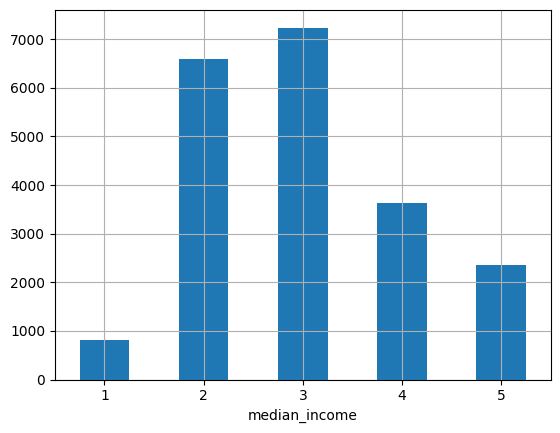

In [10]:
# stratified sampling according to income distribution
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True)

In [11]:
df_prime = df.copy()
df_prime.insert(loc=len(list(df_prime)), value=income_cat, column="income_cat")
df_st_tr, df_st_te = train_test_split(
    df_prime, test_size=0.2, stratify=df_prime["income_cat"], random_state=42
)

<Axes: xlabel='income_cat'>

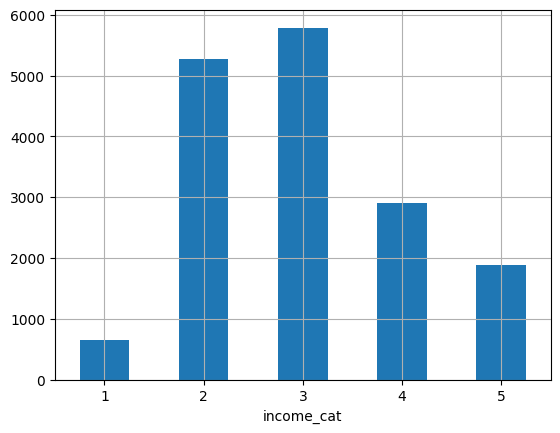

In [12]:
df_st_tr["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

<Axes: xlabel='income_cat'>

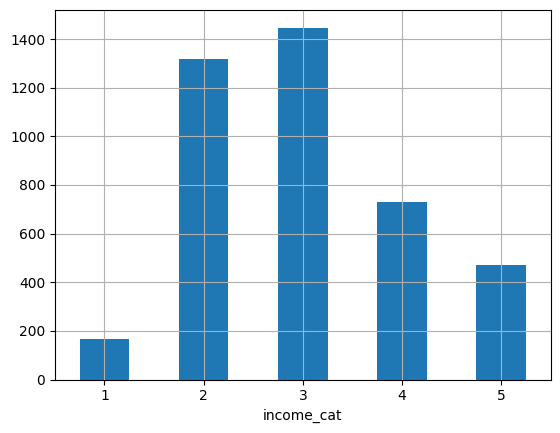

In [13]:
df_st_te["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

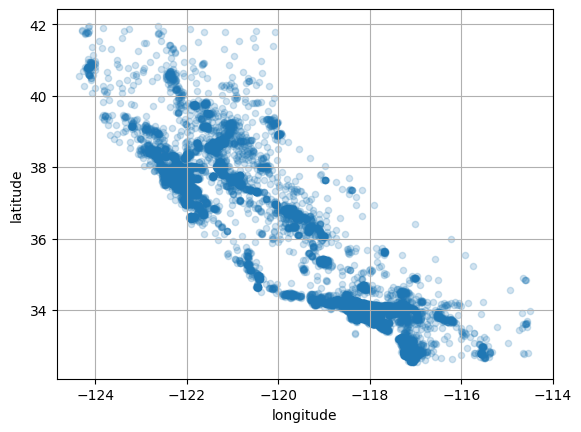

In [14]:
df_st_tr.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

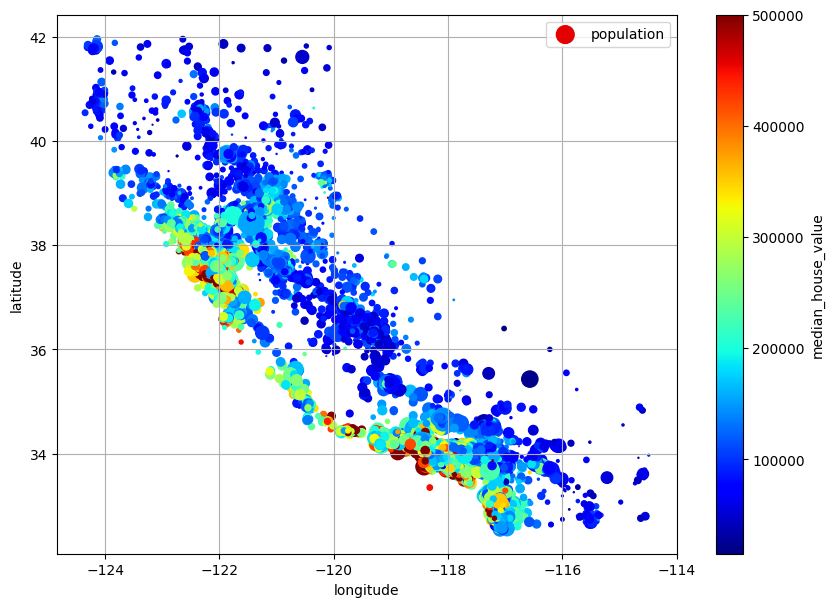

In [15]:
df_st_tr.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    s=df_st_tr["population"] / 50,
    label="population",
    c="median_house_value",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)

In [16]:
corr_matrix = df_st_tr.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

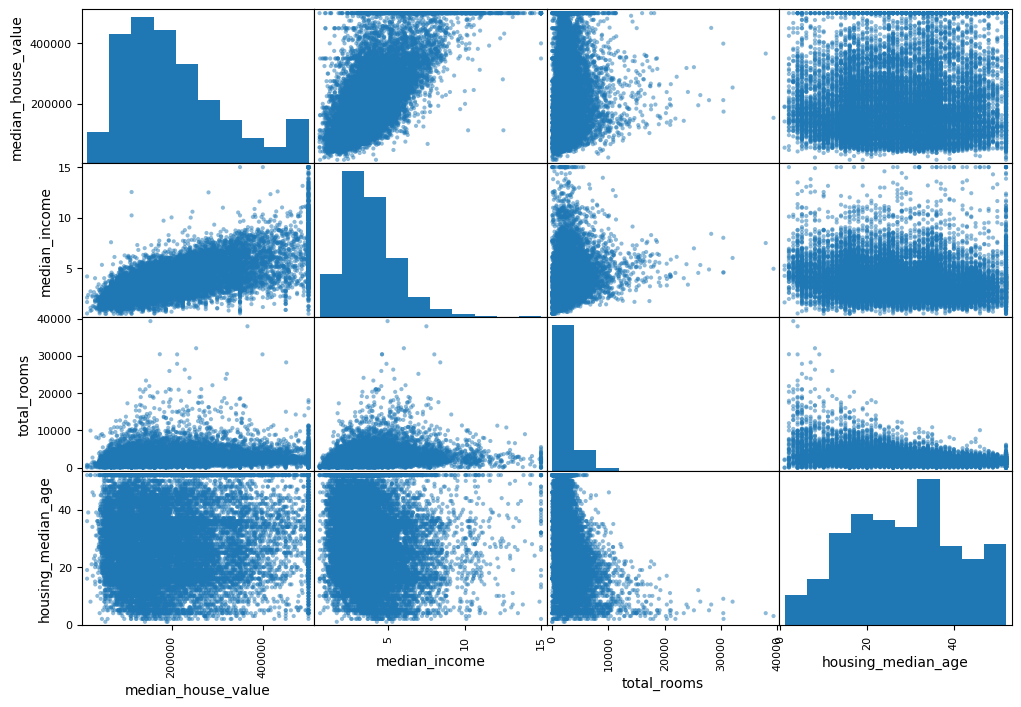

In [17]:
attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]
pd.plotting.scatter_matrix(df_st_tr[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

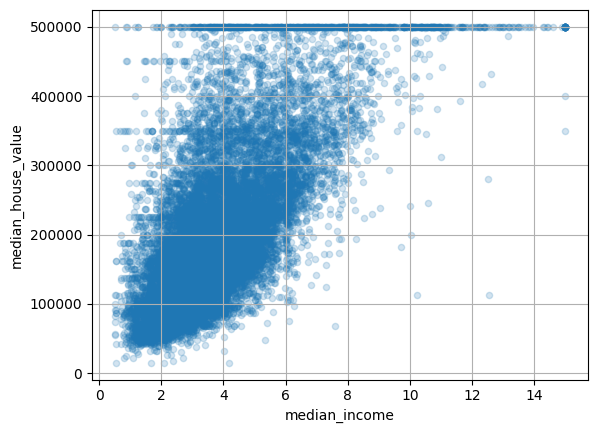

In [18]:
df_st_tr.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True)

In [19]:
display(df_st_tr.head())

rooms_per_house = df_st_tr["total_rooms"].divide(df_st_tr["households"])
bedrooms_ratio = df_st_tr["total_bedrooms"].divide(df_st_tr["total_rooms"])
people_per_house = df_st_tr["population"].divide(df_st_tr["households"])

df_st_tr["rooms_per_house"] = rooms_per_house
df_st_tr["bedrooms_ratio"] = bedrooms_ratio
df_st_tr["people_per_house"] = people_per_house

,longitude,housing_median_age,total_bedrooms,households,median_house_value,latitude,total_rooms,population,median_income,ocean_proximity,income_cat
13096,-122.42,52.0,1115.0,1034.0,458300.0,37.80,3321.0,1576.0,2.0987,NEAR BAY,2
14973,-118.38,40.0,354.0,357.0,483800.0,34.14,1965.0,666.0,6.0876,<1H OCEAN,5
3785,-121.98,33.0,217.0,203.0,101700.0,38.36,1083.0,562.0,2.4330,INLAND,2
14689,-117.11,17.0,851.0,780.0,96100.0,33.75,4174.0,1845.0,2.2618,INLAND,2
20507,-118.15,36.0,1211.0,1172.0,361800.0,33.77,4366.0,1912.0,3.5292,NEAR OCEAN,3


In [20]:
corr_matrix = df_st_tr.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64